In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [4]:
import os

# Verificar si existe el archivo combinado
combined_path = '../data/happiness_all.csv'

if not os.path.exists(combined_path):
    print("No se encontró combined_data.csv")
    print("Ejecuta primero: python etl.py")
    print("O ejecuta el notebook desde la raíz del proyecto")
else:
    # Cargar el archivo combinado directamente
    df = pd.read_csv(combined_path)
    
    print(f"\nDatos combinados cargados desde: {combined_path}")
    print(f"\nDimensiones totales: {df.shape}")
    print(f"\nRegistros por año:")
    print(df['Year'].value_counts().sort_index())
    print(f"\nColumnas disponibles:")
    print(df.columns.tolist())
    print(f"\nPrimeras filas:")
    display(df.head(10))


Datos combinados cargados desde: ../data/happiness_all.csv

Dimensiones totales: (782, 10)

Registros por año:
Year
2015    158
2016    157
2017    155
2018    156
2019    156
Name: count, dtype: int64

Columnas disponibles:
['Country', 'Region', 'Year', 'Happiness_Score', 'GDP_per_Capita', 'Social_Support', 'Healthy_Life_Expectancy', 'Freedom', 'Generosity', 'Perceptions_of_Corruption']

Primeras filas:


,Country,Region,Year,Happiness_Score,GDP_per_Capita,Social_Support,Healthy_Life_Expectancy,Freedom,Generosity,Perceptions_of_Corruption
0,Switzerland,Western Europe,2015,7.587,1.397,1.350,0.941,0.666,0.297,0.420
1,Iceland,Western Europe,2015,7.561,1.302,1.402,0.948,0.629,0.436,0.141
2,Denmark,Western Europe,2015,7.527,1.325,1.361,0.875,0.649,0.341,0.484
3,Norway,Western Europe,2015,7.522,1.459,1.331,0.885,0.670,0.347,0.365
4,Canada,North America,2015,7.427,1.326,1.323,0.906,0.633,0.458,0.330
5,Finland,Western Europe,2015,7.406,1.290,1.318,0.889,0.642,0.234,0.414
6,Netherlands,Western Europe,2015,7.378,1.329,1.280,0.893,0.616,0.476,0.318
7,Sweden,Western Europe,2015,7.364,1.332,1.289,0.911,0.660,0.363,0.438
8,New Zealand,Australia and New Zealand,2015,7.286,1.250,1.320,0.908,0.639,0.475,0.429
9,Australia,Australia and New Zealand,2015,7.284,1.334,1.309,0.932,0.651,0.436,0.356


In [9]:
# =========================
# 1) Selección de variables
# =========================
TARGET = "Happiness_Score"
FEATURES = [
    "GDP_per_Capita", "Social_Support", "Healthy_Life_Expectancy",
    "Freedom", "Generosity", "Perceptions_of_Corruption"
]

# Subconjuntos
X = df[FEATURES].copy()
y = df[TARGET].copy()

# =========================
# 2) Split train/test
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# --- Bloque explicativo ---
print("DIVISIÓN DE DATOS (70% ENTRENAMIENTO - 30% PRUEBA)")
print(f"\nConjunto de entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"\nConjunto de prueba:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"\nPorcentaje de datos de entrenamiento: {len(X_train)/len(X)*100:.1f}%")
print(f"Porcentaje de datos de prueba: {len(X_test)/len(X)*100:.1f}%")

print(f"\n✅ Dataset listo para entrenamiento con {len(X_train)} observaciones de entrenamiento y {len(X_test)} para prueba.")


DIVISIÓN DE DATOS (70% ENTRENAMIENTO - 30% PRUEBA)

Conjunto de entrenamiento:
  X_train: (547, 6)
  y_train: (547,)

Conjunto de prueba:
  X_test: (235, 6)
  y_test: (235,)

Porcentaje de datos de entrenamiento: 69.9%
Porcentaje de datos de prueba: 30.1%

✅ Dataset listo para entrenamiento con 547 observaciones de entrenamiento y 235 para prueba.


In [ ]:
# =========================
# 3) Definir modelos y función de evaluación
# =========================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test, X_full=None, y_full=None, cv=5):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    r2   = r2_score(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # CV opcional sobre todo el dataset (da una idea de estabilidad)
    if X_full is None: X_full = pd.concat([X_train, X_test], axis=0)
    if y_full is None: y_full = pd.concat([y_train, y_test], axis=0)
    cv_r2 = cross_val_score(modelo, X_full, y_full, cv=cv, scoring="r2").mean()

    return {
        "Modelo": nombre,
        "R2_test": round(float(r2), 3),
        "RMSE_test": round(float(rmse), 3),
        "MAE_test": round(float(mae), 3),
        "CV_R2_mean": round(float(cv_r2), 3),
        "fitted": modelo
    }

modelos = [
    (LinearRegression(), "LinearRegression"),
    (RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1), "RandomForest"),
    (GradientBoostingRegressor(random_state=42), "GradientBoosting")
]

In [11]:
# =========================
# 4) Entrenar, evaluar y comparar
# =========================
resultados = [evaluar_modelo(m, n, X_train, y_train, X_test, y_test, X, y) for m, n in modelos]

res_df = (pd.DataFrame([{k:v for k,v in r.items() if k!="fitted"} for r in resultados])
          .sort_values("R2_test", ascending=False)
          .reset_index(drop=True))
print("Resultados en TEST:")
display(res_df)


Resultados en TEST:


,Modelo,R2_test,RMSE_test,MAE_test,CV_R2_mean
0,RandomForest,0.782,0.522,0.409,0.781
1,GradientBoosting,0.757,0.550,0.419,0.756
2,LinearRegression,0.727,0.584,0.449,0.739


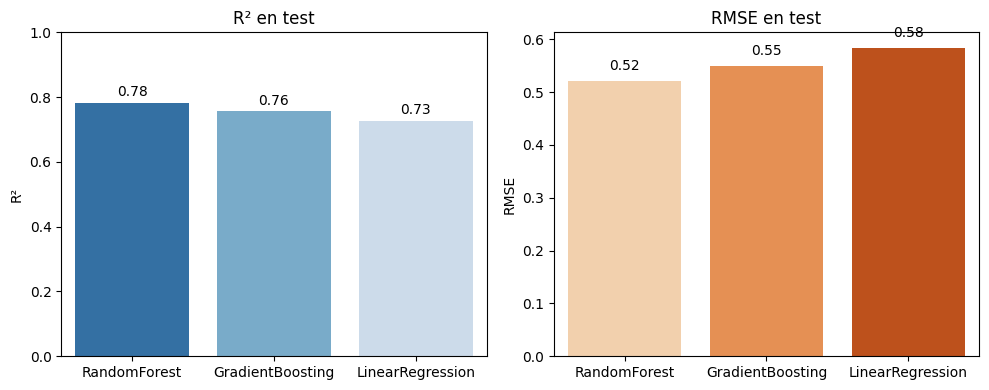

In [12]:
# =========================
# 5) Gráficas comparativas
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.barplot(data=res_df, x="Modelo", y="R2_test", hue="Modelo", dodge=False, legend=False, palette="Blues_r")
plt.ylim(0,1); plt.title("R² en test"); plt.xlabel(""); plt.ylabel("R²")
for i, v in enumerate(res_df["R2_test"]): plt.text(i, v+0.02, f"{v:.2f}", ha="center")

plt.subplot(1,2,2)
sns.barplot(data=res_df, x="Modelo", y="RMSE_test", hue="Modelo", dodge=False, legend=False, palette="Oranges")
plt.title("RMSE en test"); plt.xlabel(""); plt.ylabel("RMSE")
for i, v in enumerate(res_df["RMSE_test"]): plt.text(i, v+0.02, f"{v:.2f}", ha="center")

plt.tight_layout(); plt.show()


Mejor modelo: RandomForest


,Modelo,R2_test,RMSE_test,MAE_test,CV_R2_mean
0,RandomForest,0.782,0.522,0.409,0.781


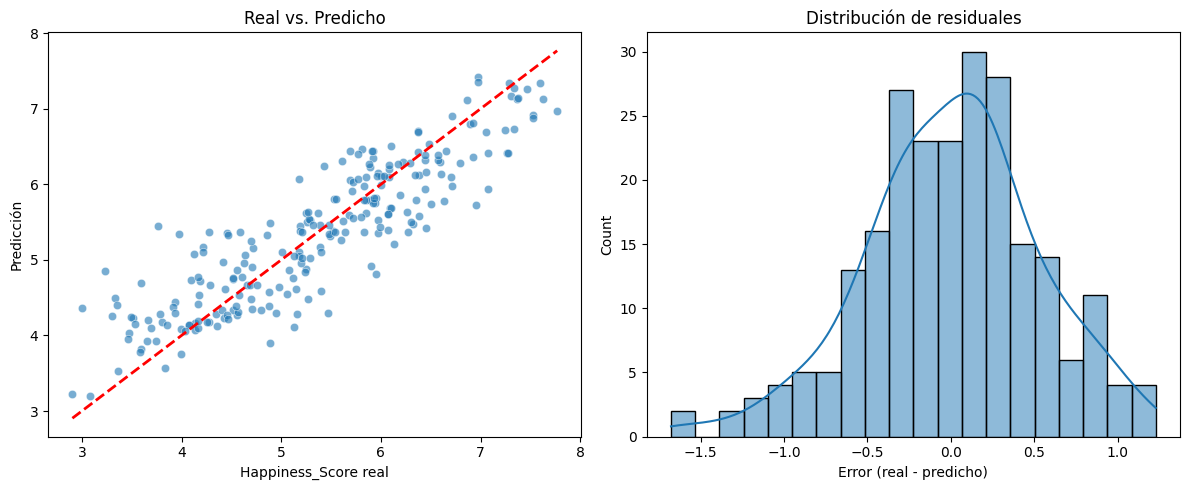

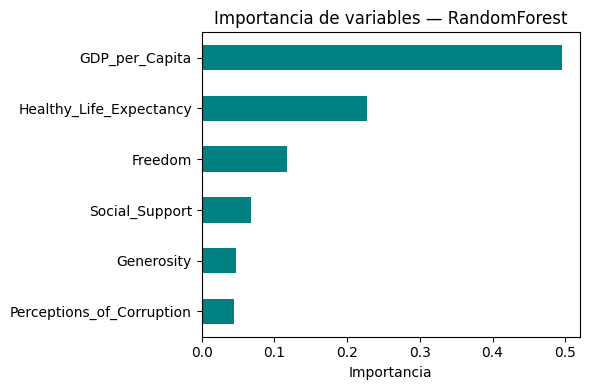

In [13]:
# =========================
# 6) Selección del mejor y diagnósticos
# =========================
mejor = max(resultados, key=lambda r: r["R2_test"])
best_model = mejor["fitted"]
print("Mejor modelo:", mejor["Modelo"])
display(pd.DataFrame([mejor]).drop(columns=["fitted"]))

# Visuales: Real vs Predicho y residuales
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.title("Real vs. Predicho"); plt.xlabel("Happiness_Score real"); plt.ylabel("Predicción")

plt.subplot(1,2,2)
resid = y_test - y_pred_best
sns.histplot(resid, bins=20, kde=True)
plt.title("Distribución de residuales"); plt.xlabel("Error (real - predicho)")
plt.tight_layout(); plt.show()

# Importancia de features (si aplica)
from sklearn.inspection import permutation_importance

if hasattr(best_model, "feature_importances_"):
    imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=True)
    plt.figure(figsize=(6,4))
    imp.plot(kind="barh", color="teal")
    plt.title(f"Importancia de variables — {mejor['Modelo']}")
    plt.xlabel("Importancia"); plt.ylabel("")
    plt.tight_layout(); plt.show()
else:
    # Alternativa: importancia por permutación (modelo-agnóstica)
    perm = permutation_importance(best_model, X_test, y_test, scoring="r2", n_repeats=20, random_state=42)
    perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=True)
    plt.figure(figsize=(6,4))
    perm_imp.plot(kind="barh", color="slateblue")
    plt.title(f"Importancia (permutación) — {mejor['Modelo']}")
    plt.xlabel("ΔR² promedio"); plt.ylabel("")
    plt.tight_layout(); plt.show()
